# VWAP with Tick Data v1

## Parameters
Parameters: &lt;side&gt; &lt;quantity&gt; [limit_px]  
side = "b" (buy) or "s" (sell)  
quantity = # of shares  
limit_px = limit price (optional)  

In [44]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.interpolation import shift
import pandas as pd
import time
import datetime

matplotlib.rcParams[ 'figure.figsize' ] = ( 14, 6 )

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def show_time( label_string ):
    ts = time.time()
    st = datetime.datetime.fromtimestamp( ts ).strftime( '%Y-%m-%d %H:%M:%S:%f' )
    print( label_string + ' : ' + st )

In [18]:
vwap_coefs = [ 7.49930092e-03, -5.05137528e-05,  2.26416619e-07, -5.19862243e-10, 4.79918459e-13 ]

# returns next minute target
# scale the last value to ensure it converges to 1 by the end and then shift the series by back by one
def get_vwap_targets( order_size, coefs ):
    bar_num = np.arange( 0, 391 )
    bar_pcts = ( coefs[ 0 ] * bar_num + 
                coefs[ 1 ] * bar_num ** 2 + 
                coefs[ 2 ] * bar_num ** 3 + 
                coefs[ 3 ] * bar_num ** 4 + 
                coefs[ 4 ] * bar_num ** 5 )
    bar_pcts = bar_pcts / ( coefs[ 0 ] * 390 + 
                coefs[ 1 ] * 390 ** 2 + 
                coefs[ 2 ] * 390 ** 3 + 
                coefs[ 3 ] * 390 ** 4 + 
                coefs[ 4 ] * 390 ** 5 )
    bar_pcts = shift( bar_pcts, -1, cval=1 )
    return np.minimum( ( bar_pcts * order_size ).astype( int ), order_size )

### Set up our market data

In [68]:
# load our taq file
taq = pd.read_pickle( 'TWTR_taq_20190131.gz' )

# get all the trades for later too
market_trades = pd.read_pickle ( 'TWTR_trades_201901.gz' )
market_trades = market_trades[ '2019-01-31' ]
market_trades = market_trades.between_time('09:30:00', '16:00:00')



In [20]:
# generate target schedule - use bins 1 - 390 giving an automatic 1 minute "look ahead"
# note that targets have been converted to shares from percent
order_targets = get_vwap_targets( order_quantity, vwap_coefs )

In [22]:
# check our data
taq.head()

,EX_x,bid_price,bid_qty,ask_price,ask_qty,QU_COND,NATBBO_IND,QU_CANCEL,EX_y,TR_SCOND,trade_qty,trade_price,TR_SOURCE
2019-01-31 09:30:00.056871693,Z,32.96,17.0,33.18,2.0,R,A,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-31 09:30:00.057456000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T,T,100.0,33.08,C
2019-01-31 09:30:00.057496000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T,T,400.0,33.07,C
2019-01-31 09:30:00.057883273,B,31.33,1.0,35.24,1.0,R,A,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-31 09:30:00.058768165,P,33.05,1.0,33.15,1.0,R,G,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
len(taq)

2104802

### VWAP Simulation

In [53]:
# set order parameters
order_side = "b"
order_quantity = 250000

# initialize some other variables
current_bar = 1
current_target = 0
quantity_filled = 0
quantity_remaining = order_quantity - quantity_filled
bid_price = 0.0
bid_quantity = 0.0
offer_price = 0.0
offer_quantity = 0.0
last_price = 0.0
last_quantity = 0.0
total_volume = 0.0
vwap_numerator = 0.0
trades_arr = []

# main event loop
show_time( 'start loop' )
for index, row in taq.iterrows():
    # figure out which minute we are in after the open
    time_from_open = ( index - pd.Timedelta( hours = 9, minutes = 30 ) )
    minutes_from_open = ( time_from_open.hour * 60 ) + time_from_open.minute
        
    # determine message type
    if ( pd.isnull( row[ 'trade_qty' ] ) ): # it's a quote
        # collect BBO
        bid_price = row[ 'bid_price' ]
        offer_price = row[ 'ask_price' ]
        
        # what's wrong with the lines below?
        bid_quantity = row[ 'bid_qty' ] * 100 
        offer_quantity = row[ 'ask_qty' ] * 100
    
    else: # it's a trade
        last_price = row[ 'trade_price' ]
        last_quantity = row[ 'trade_qty' ]
        
        # collect volume
        total_volume += last_quantity
        
        # collect rolling VWAP
        vwap_numerator += last_quantity * last_price

    # are we in a new minute?
    if ( minutes_from_open > current_bar ):
        # we're in a new bar do new bar things here
        current_bar = minutes_from_open
        current_target = min( np.ceil( order_targets[ current_bar ] ), order_quantity )
        #print ( str(current_bar) + ': ' + str( current_target ) )
        
    # trade logic
    # v1: are we behind the target at all? If so, do a trade, just pay the spread
    quantity_behind = current_target - quantity_filled
    if ( quantity_behind > 0 ): # we need to trade 
        
        # assume you can execute the full size across spread
        new_trade_quantity = quantity_behind
        if ( order_side == 'b' ):
            new_trade_price = offer_price
        else: 
            new_trade_price = bid_price
            
        # do we have a valid last trade price? if not, we should skip, because market data is bad. 
        if new_trade_price == 0:
            # something is wrong, wait for market data to update
            continue
        
        trades_arr.append( ( new_trade_price, new_trade_quantity, current_bar, index ) )
        
        # update quantity remaining
        quantity_remaining = min( 0, quantity_remaining - new_trade_quantity )
        quantity_filled += new_trade_quantity    
        
# looping done
show_time( 'end loop' )

start loop : 2019-04-19 18:37:02:015127
end loop : 2019-04-19 18:42:52:002880


In [54]:
# Now, let's look at some stats
#trades = trades.dropna()

trades_df = pd.DataFrame( trades_arr, columns=[ 'trade_price', 'trade_qty', 'bar', 'time' ] )
trades_df.index = pd.to_datetime( trades_df[ 'time' ] )
trades_df = trades_df.drop( columns = ['time'] )

In [55]:
day_vwap = vwap_numerator / total_volume
print( 'stock volume: ' + str( total_volume ) )
print( 'order shares traded: ' + str( quantity_filled ) )
avg_price = (trades_df[ 'trade_price' ] * trades_df[ 'trade_qty' ]).sum() / trades_df[ 'trade_qty' ].sum()
print( 'average price: ' + str( avg_price ) )
print( 'day vwap: ' + str( day_vwap ) )
print( 'average trade size: ' + str( trades_df[ 'trade_qty' ].mean() ) )

stock volume: 17413086.0
order shares traded: 250000.0
average price: 33.420225
day vwap: 33.37724710915122
average trade size: 644.3298969072165


In [56]:
trades_df[ 'accum_shares' ] = trades_df[ 'trade_qty' ].cumsum()

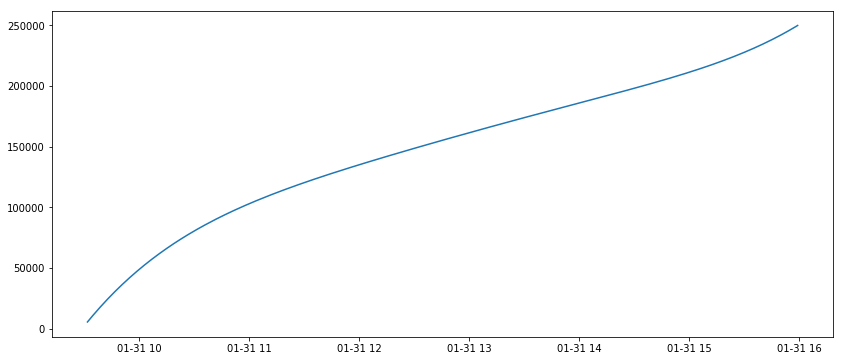

In [57]:
plt.plot( trades_df[ 'accum_shares' ] )

Text(0.5, 1.0, 'realized trade prices')

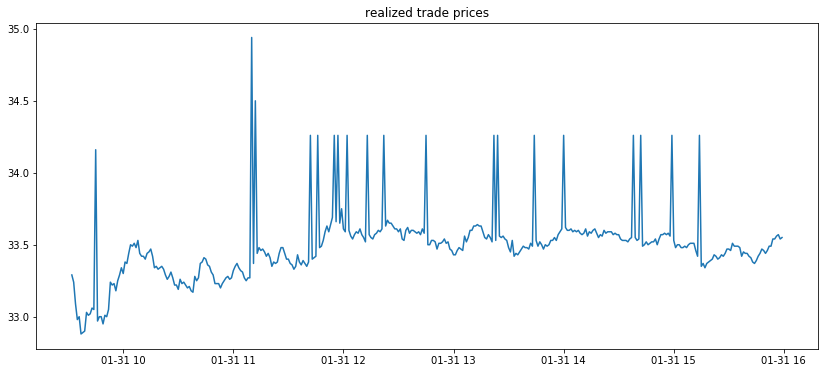

In [58]:
plt.plot(trades_df[ 'trade_price' ] )
plt.title( 'realized trade prices' )

In [51]:
trades_df[trades_df[ 'trade_price' ] == 0 ]

,trade_price,trade_qty,bar,accum_shares
time,,,,
2019-01-31 09:58:00.006976879,0.0,1313.0,28,46161.0
2019-01-31 10:08:00.016280063,0.0,1154.0,38,58396.0
2019-01-31 10:19:00.021910661,0.0,1006.0,49,70175.0
2019-01-31 10:44:00.013179177,0.0,758.0,74,91860.0
2019-01-31 10:47:00.021671487,0.0,735.0,77,94087.0
2019-01-31 11:28:00.007362832,0.0,533.0,118,119359.0


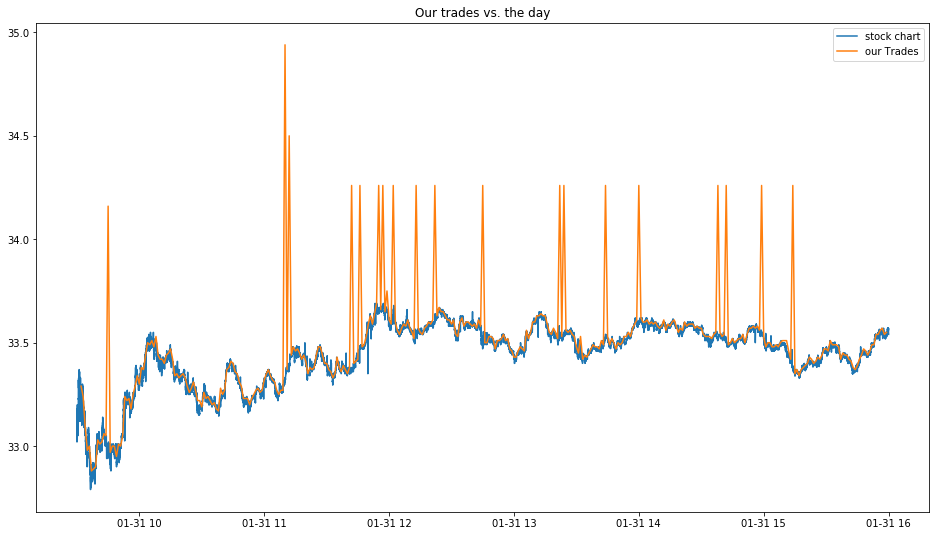

In [69]:
fig, ax1 = plt.subplots( figsize = ( 16, 9 ) )

ax1.plot( market_trades[ 'trade_price' ], label = 'stock chart' )
ax1.plot( trades_df[ 'trade_price' ], label = 'our Trades' )
plt.title( 'Our trades vs. the day' )
plt.legend()

In [70]:
len(trades_df)

388